# Exemplo de ajuste modelo não linear
Para o ajuste de modelo não linear de equação analítica, é necessário realizar os seguintes passos:

1. Descrever o modelo a ser ajustado, preferível na forma de função no R;

    - Exemplo 1, curva de retenção de água no solo, modelo de [van Genuchten (1980)](http://people.ucalgary.ca/~hayashi/glgy607/reading/van_Genuchten1980.pdf): $$\theta(h) = \theta_S \cdot \left[1 + \left(\frac{h}{h_g}\right)^n \right]^{-(1-2/n)}$$
    - Exemplo 2, curva de infiltração, modelo de [Haverkamp *et al.* (1994)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94WR01788): $$I(t) = S \sqrt{t} + [aS^2 + bK_s]t$$

2. Identificar os parâmetros a ser ajustados;
3. Ajustar o modelo aos dados informados utilizando a função **nls()**;
4. Avaliar a qualidade do ajuste;
5. Apresentar resultados.

In [1]:
# Pacotes --------------------------------------------------------------
library('hydroGOF')        # Calcular qualidade do ajuste


Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 


In [2]:
# Exemplo 1 -----------------------------------------------------------
# Equação de van Genuchten (1980)
# Passo 1 - Descrever o modelo
vgF = function(h, thetaS, hg, n){
    return(thetaS*(1+(h/hg)^n)^-(1-2/n))
}

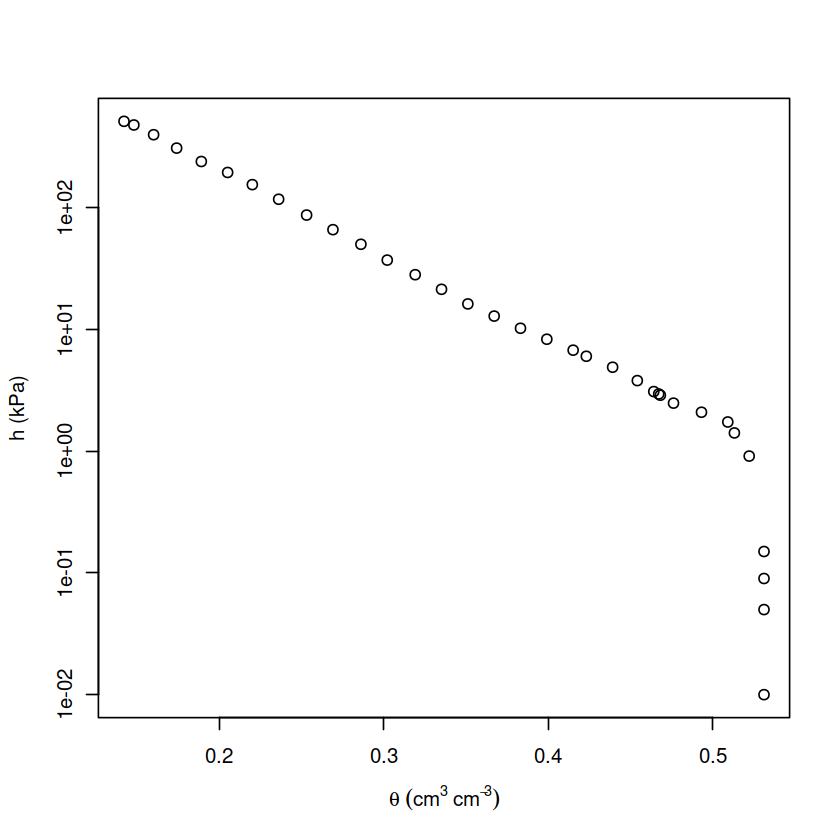

In [3]:
# Passo 2 - Identificar os parâmetros que precisam ser ajustados
# considerando que normalmente é fornecido o theta e h, nesse caso,
# é necessário ajustar hg e n.

theta = c(0.531, 0.531, 0.531, 0.531, 0.522, 0.513, 0.509, 0.493, 0.476,
          0.467, 0.468, 0.464, 0.454, 0.439, 0.423, 0.415, 0.399, 0.383,
          0.367, 0.351, 0.335, 0.319, 0.302, 0.286, 0.269, 0.253, 0.236,
          0.220, 0.205, 0.189, 0.174, 0.160, 0.148, 0.142)

h = c(0.010, 0.050, 0.090, 0.150, 0.912, 1.413, 1.738, 2.090, 2.483, 2.952,
      2.884, 3.090, 3.802, 4.898, 6.026, 6.761, 8.318, 10.233, 12.882, 16.218,
      21.380, 28.184, 37.154, 50.119, 66.069, 87.096, 117.490, 154.882, 194.984,
      239.883, 309.030, 398.107, 478.630, 512.861)

# Gráfico das variávels
plot(theta, h, log='y', xlab=expression(theta~(cm^{3}~cm^{-3})), ylab = 'h (kPa)')



In [4]:
# Passo 3 - Ajustar o modelo aos dados.
fit1 = nls(theta~vgF(h, thetaS = max(theta), hg, n), start=list(hg=2, n=2.1))
summary(fit1)
cf1 = coef(fit1)


Formula: theta ~ vgF(h, thetaS = max(theta), hg, n)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
hg  2.12566    0.11104   19.14   <2e-16 ***
n   2.21135    0.00465  475.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.009651 on 32 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 2.369e-06


In [5]:
# Passo 4 - Avaliar qualidade do ajuste
qfit1 = gof(sim = predict(fit1), obs = theta)
qfit1

ME,0.00
MAE,0.01
MSE,0.00
RMSE,0.01
NRMSE %,7.20
PBIAS %,0.20
RSR,0.07
rSD,0.99
NSE,0.99
mNSE,0.94
rNSE,0.98


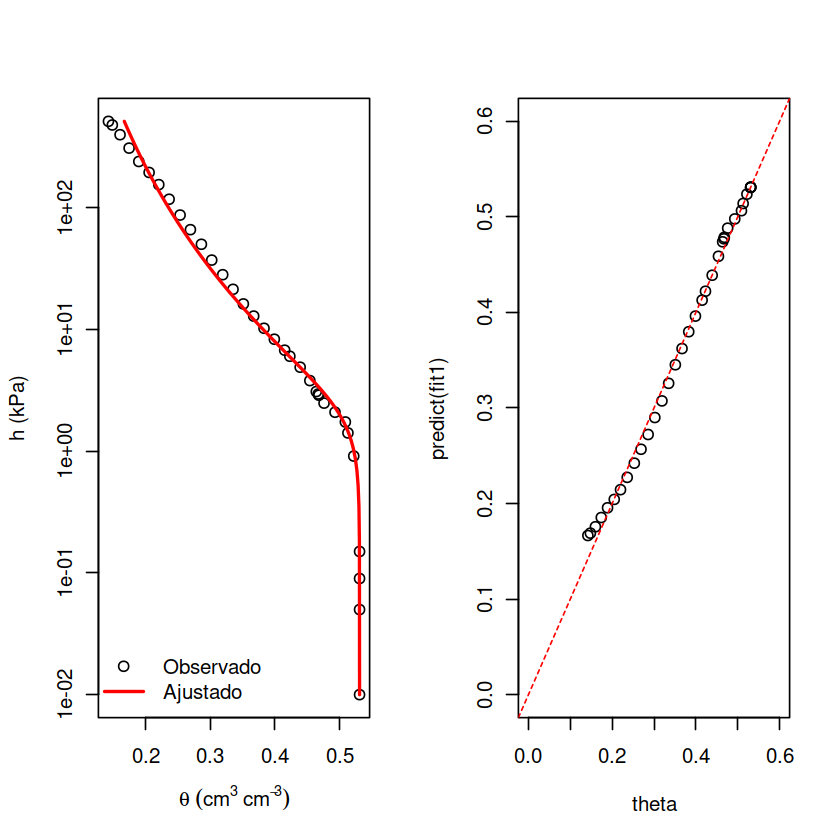

In [6]:
# Passo 5 - Apresentar os resultados...
# Calculando theta a partir do modelo
ht = seq(min(h), max(h), length=3000)
thetat = vgF(h = ht, thetaS = max(theta), hg = cf1[1], n = cf1[2])

par(mfrow=c(1,2))
plot(theta, h, log='y', xlab=expression(theta~(cm^{3}~cm^{-3})), ylab = 'h (kPa)')
lines(thetat, ht, lwd=2, col='red')
legend('bottomleft', legend = c('Observado', 'Ajustado'), pch=c(1,NA), lwd=c(NA,2),
       col=c('black', 'red'), bty='n')

plot(theta, predict(fit1), xlim=c(0,0.6), ylim=c(0,0.6))
abline(a=0, b=1, lwd=1, lty=2, col='red') # Linha 1:1

In [7]:
# Exemplo 2 -----------------------------------------------------------
# Equação de Haverkamp et al. (1994)
# Na equação de Haverkam, a e b são constantes (a = 0.025 e b = 0.467)

# Passo 1 - Descrever modelo
hkF = function(tempo, Ks, S){
    a = 0.025
    b = 0.467
    return(S*tempo^0.5 + (a*S^2 + b*Ks)*tempo)
}

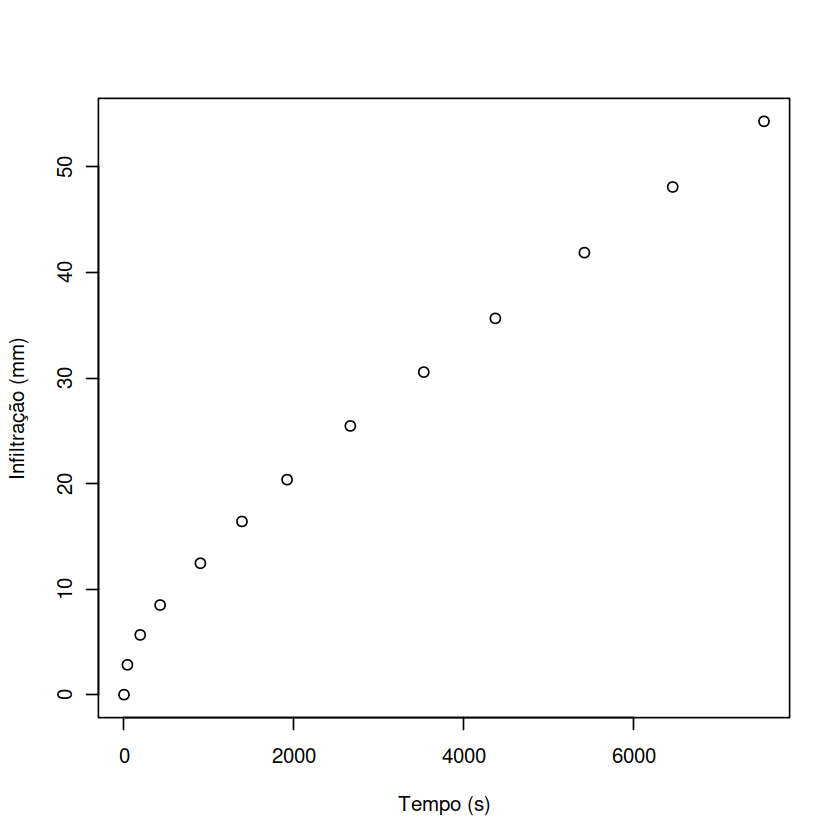

In [8]:
# Passo 2 - Identificar as variáveis para ajustar. Nesse caso S e Ks, uma vez
# que a e b são constantes já fornecidas.

# Dados
# Tempo (s)
tempo = c(0, 40, 191, 425, 899, 1388, 1919, 2663, 3527,
          4369, 5417, 6456, 7530)

# Lâmina de infiltração acumulada (mm)
infil = c(0.00, 2.83, 5.66, 8.49, 12.45, 16.41, 20.37,
          25.46, 30.56, 35.65, 41.88, 48.10, 54.32)


plot(tempo, infil, xlab='Tempo (s)', ylab='Infiltração (mm)')


In [9]:
# Passo 3 - Ajustar os parâmetros
fit2 = nls(infil~hkF(tempo, Ks, S), start=list(Ks = 0.001, S = 0.002))
summary(fit2)
cf2 = coef(fit2)


Formula: infil ~ hkF(tempo, Ks, S)

Parameters:
    Estimate Std. Error t value Pr(>|t|)    
Ks 0.0025387  0.0006131   4.141  0.00164 ** 
S  0.3093842  0.0097266  31.808 3.53e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4407 on 11 degrees of freedom

Number of iterations to convergence: 2 
Achieved convergence tolerance: 2.302e-07


In [10]:
# Passo 4 - Avaliar qualidade do ajuste
qfit2 = gof(sim = predict(fit2), obs = infil)
qfit2

Warning message:
“'rNSE' can not be computed: some elements in 'obs' are zero !”Warning message:
“'rd' can not be computed: some elements in 'obs' are zero !”

ME,-0.10
MAE,0.31
MSE,0.16
RMSE,0.41
NRMSE %,2.30
PBIAS %,-0.40
RSR,0.02
rSD,1.01
NSE,1.00
mNSE,0.98
rNSE,NaN


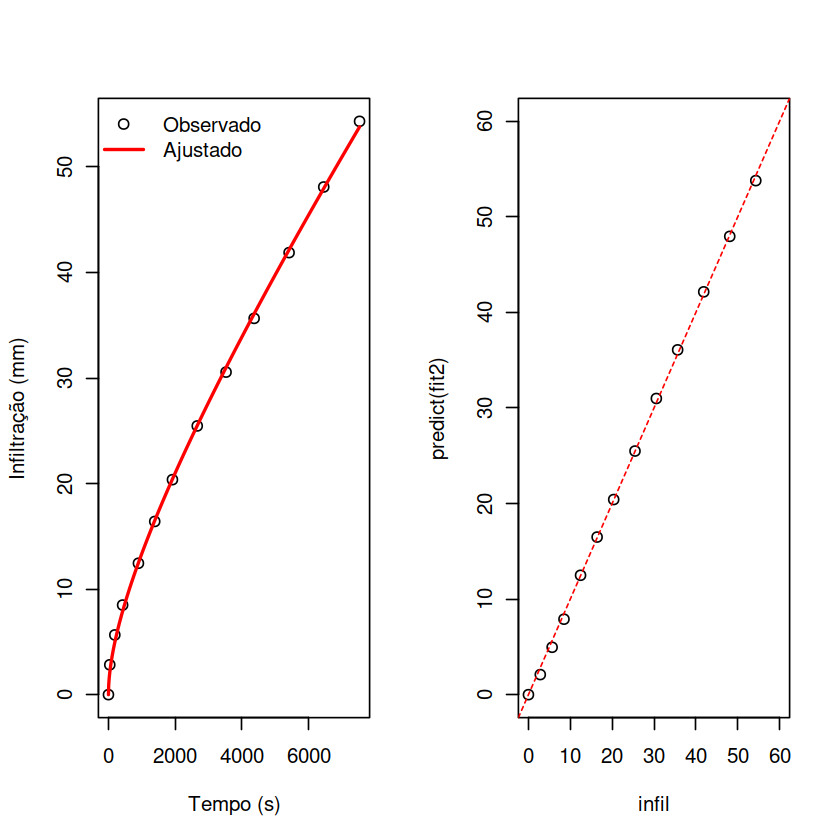

In [11]:
# Passo 5 - Apresentar resultados...
tempot = seq(min(tempo), max(tempo), length=1000)
infilt = hkF(tempot, Ks = cf2[1], S = cf2[2])


par(mfrow=c(1,2))
plot(tempo, infil, xlab='Tempo (s)', ylab='Infiltração (mm)')
lines(tempot, infilt, lwd=2, col='red')

legend('topleft', legend = c('Observado', 'Ajustado'), pch=c(1,NA), lwd=c(NA,2),
       col=c('black', 'red'), bty='n')


plot(infil, predict(fit2), xlim=c(0,60), ylim=c(0,60))
abline(a=0, b=1, lwd=1, lty=2, col='red') # Linha 1:1